# Computing warmest weeks to take vacation in

One must download the dataset from FTP: ftp://ftp.ncdc.noaa.gov//pub/data/ghcn/daily/by_station/&lt;name of the station&gt;.dly

List of weather stations for your city is ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt


In [41]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import date, datetime, timedelta

from matplotlib import pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

plt.rcParams['figure.figsize'] = [14, 6]

In [2]:
f = Path("./RSM00027612.csv")
targetYear = 2022
lowerBound = (5, 30)
upperBound = (9, 4)

In [16]:
def getSubDataset(d, t):
    sds = d.loc[d.loc[:, "type"] == t]
    sds = sds.drop(columns=["type",])
    return sds

def aggregateSubDatasetsIntoSameTable(d, types):
    types = iter(types)
    t = next(types)
    res = getSubDataset(d, t)
    res = res.rename(columns={"value": t})
    
    for t in types:
        sds = getSubDataset(d, t)
        res = res.join(sds, how="outer")
        res = res.rename(columns={"value": t})
    return res

tempColumns = ["TMAX", "TAVG", "TMIN"]
cols = tuple(tempColumns) + ( "PRCP", "SNWD")

def importTemperatureDataset(f):
    d = pd.read_csv(f, header=None)
    d.columns = ("ID", "YMD", "type", "value", "measurement", "quality", "source", "unkn4")
    d = d.drop(columns=["unkn4", "ID"])
    d=d.loc[d['quality'].isna()]
    d = d.drop(columns=["quality",])
    d["year"] = d.loc[:, "YMD"] // 10000
    d["month"] = (d.loc[:, "YMD"] // 100)  % 100
    d["day"] = d.loc[:, "YMD"] % 100
    d = d.drop(columns=["YMD",])
    d = d.set_index(["year", "month", "day"])

    d = d.drop(columns=["source", "measurement"])
    return aggregateSubDatasetsIntoSameTable(d, cols)

ad = importTemperatureDataset(f)

In [17]:
tempz = ad.loc[(slice(2000, None), slice(None, None), slice(None, None)), tempColumns]
g = tempz.groupby(level=["month", "day"])
mt = g.median()
mt =  mt.loc[(slice(3, 10),slice(None, None))]

def mapToTargetYerDates(x):
    return datetime(targetYear, int(x.month), int(x.day))

mt = mt.reset_index()
mt.loc[:, "date"] = mt.apply(mapToTargetYerDates, axis=1)
mt = mt.drop(columns=["month", "day"])
mt = mt.set_index(["date"])


In [18]:
roi = mt.loc[date(targetYear, *lowerBound):date(targetYear, *upperBound), :]
assert (len(roi) / 7).is_integer()

In [19]:
def getBeginningOfWeek(dd):
    return dd - timedelta(days=(dd.isoweekday() - 1))

weeks = roi.groupby(by=getBeginningOfWeek).mean()

In [20]:
weeks.sort_values("TMAX", ascending=False).iloc[:6]

TMAX        TAVG        TMIN
2022-07-25  266.928571  210.928571  162.928571
2022-07-11  264.500000  209.714286  161.928571
2022-07-18  249.714286  200.357143  149.571429
2022-08-01  249.285714  189.000000  147.428571
2022-08-08  247.500000  187.857143  137.000000
2022-07-04  242.928571  204.714286  144.571429

In [13]:
weeks.sort_values("TMIN", ascending=False).iloc[:6]

TMAX        TAVG        TMIN
2022-07-25  266.928571  210.928571  162.928571
2022-07-11  264.500000  209.714286  161.928571
2022-07-18  249.714286  200.357143  149.571429
2022-08-01  249.285714  189.000000  147.428571
2022-07-04  242.928571  204.714286  144.571429
2022-08-15  241.928571  185.000000  140.785714

In [14]:
weeks.sort_values("TAVG", ascending=False).iloc[:6]

TMAX        TAVG        TMIN
2022-07-25  266.928571  210.928571  162.928571
2022-07-11  264.500000  209.714286  161.928571
2022-07-04  242.928571  204.714286  144.571429
2022-07-18  249.714286  200.357143  149.571429
2022-08-01  249.285714  189.000000  147.428571
2022-08-08  247.500000  187.857143  137.000000

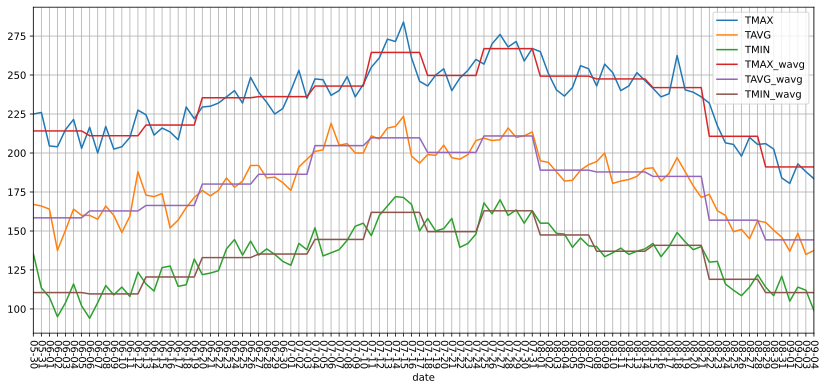

In [42]:
def weekAverageResample():
    for w in weeks.reset_index().iloc:
        r = list(w)
        for i in range(7):
            yield [r[0] + timedelta(days=i)] + r[1:]

smD = pd.DataFrame(weekAverageResample())
smD.columns = ["date"] + list(weeks.columns)
smD = smD.set_index(["date"])
aggr = roi.join(smD, rsuffix="_wavg")
ax = aggr.plot()
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m-%d"))
plt.xticks(rotation=-90)
plt.grid()